In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Data.zip

In [3]:
class_names =['Bedroom','Coast','Forest','Highway','Industrial','Inside_City','Kitchen','Livingroom','Mountain','Office',
              'Open_Country', 'Store', 'Street', 'Suburb', 'Tall_Building']

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise
from skimage.filters import gaussian

In [5]:
def apply_augmentation():
  for name in class_names:
    path = '/content/Data/Train/' + name
    dirListing = os.listdir(path)
    for filename in dirListing:
      im = cv2.imread('/content/Data/Train/' + name + '/'+filename)
      im =cv2.resize(im,(227,227))
      cv2.imwrite('/content/Data/Train/' + name + '/'+filename,im)

      flipped = np.fliplr(im)
      cv2.imwrite('/content/Data/Train/' + name + '/'+ "flipped-"+filename,flipped)

      noisyRandom = random_noise(im,var=0.155**2)
      cv2.imwrite('/content/Data/Train/' + name + '/'+ "noisy-"+filename,flipped)

      blurred = gaussian(im,sigma=1,multichannel=True)
      cv2.imwrite('/content/Data/Train/' + name + '/'+ "blurred-"+filename,flipped)




  for name in class_names:
    path = '/content/Data/Test/' + name
    dirListing = os.listdir(path)
    for filename in dirListing:
      im = cv2.imread('/content/Data/Test/' + name + '/'+filename)
      im =cv2.resize(im,(227,227))
      cv2.imwrite('/content/Data/Test/' + name + '/'+filename,im)

      
      flipped = np.fliplr(im)
      cv2.imwrite('/content/Data/Test/' + name + '/'+ "flipped-"+filename,flipped)



      noisyRandom = random_noise(im,var=0.155**2)
      cv2.imwrite('/content/Data/Test/' + name + '/'+ "noisy-"+filename,flipped)

      blurred = gaussian(im,sigma=1,multichannel=True)
      cv2.imwrite('/content/Data/Test/' + name + '/'+ "blurred-"+filename,flipped)

  return

In [6]:
def plot_learned(train_loss, train_acc, test_loss, test_acc, train_top5_list, test_top5_list):

  fig, axs = plt.subplots(1,3)
 
  axs[0].plot(train_loss,color='blue')
  axs[0].plot(test_loss,color='green')
  axs[0].set_title('Loss')
  axs[0].legend(['Train','Test'])


  axs[1].plot(train_acc,color='blue')
  axs[1].plot(test_acc,color='green')
  axs[1].set_title('Accuracy top1')
  axs[1].legend(['Train','Test'])


  axs[2].plot(train_top5_list,color='blue')
  axs[2].plot(test_top5_list,color='green')
  axs[2].set_title('Accuracy top5')
  axs[2].legend(['Train','Test'])


  fig.set_size_inches(30, 8)


  plt.show()

  return

In [7]:
apply_augmentation()
print("done")

done


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD

In [11]:
BATCH_SIZE = 64
transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

trainset = torchvision.datasets.ImageFolder('/content/Data/Train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder('/content/Data/Test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,shuffle=False, num_workers=2)

In [34]:
model = nn.Sequential(
    #no.1
    nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),  
    nn.ReLU(),
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  
    nn.MaxPool2d(kernel_size=3, stride=2), 

    #no.2
    nn.BatchNorm2d(96),
    nn.Conv2d(96, 256, 5, padding=2),  
    nn.ReLU(),
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
    nn.MaxPool2d(kernel_size=3, stride=2),  

    #no.3
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 384, 3,stride=2, padding=1),  
    nn.ReLU(),

    #no.4
    nn.BatchNorm2d(384),
    nn.Conv2d(384, 384, 3, padding=1),  
    nn.ReLU(),

    #no.5
    nn.Conv2d(384, 256, 3, padding=1),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    
    nn.AdaptiveAvgPool2d(output_size=(6, 6)),
    nn.Flatten(),

    #no.6
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
    nn.ReLU(),

    #no.7
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(),
    
    #no.8
    nn.Linear(in_features=4096, out_features=len(class_names)),

    )

In [35]:
## test the model with 1 batch
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([64, 3, 227, 227])
torch.Size([64, 15])


In [36]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [37]:
def get_top5(output, target, topk=(1,5)):
    maxk = max(topk)  

    _, pred = torch.topk(input=output, k=5, dim=1, largest=True, sorted=True)
    pred = pred.t()

    target_reshaped = target.view(1, -1).expand_as(pred)  
    correct = (pred == target_reshaped)


    sum1 = torch.sum(correct, 1)
    sum2 = torch.sum(sum1)

    return sum2 *100.0 / BATCH_SIZE

In [38]:
learning_rate = 0.001
num_epochs = 50


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.5)

lmbda = lambda epoch: 0.95
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [39]:
all_train_loss=[]
all_train_acc=[]

all_test_acc=[]
all_test_loss=[]


train_top5_list=[]
test_top5_list=[]

In [42]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    train_top5_acc = 0.0

    model = model.train()

    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
        train_top5_acc += get_top5(logits, labels)

    model.eval()


    test_acc = 0.0
    test_running_loss = 0.0
    test_top5_acc =0.0

    for j, (images, labels) in enumerate(testloader, 0):

      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      test_running_loss += loss.detach().item()
      test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
      test_top5_acc += get_top5(outputs, labels)


    scheduler.step()

    all_train_loss.append(train_running_loss /i )
    all_train_acc.append(train_acc/i)
    train_top5_list.append(train_top5_acc/(i))

    all_test_loss.append(test_running_loss/j)
    all_test_acc.append(test_acc/j)
    test_top5_list.append(test_top5_acc/j)

    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f | Test Accuracy: %.2f | Test loss: %.4f' \
          %(epoch, train_running_loss / i, train_acc/i, test_acc/j, test_running_loss/j)) 

Epoch: 0 | Loss: 0.5647 | Train Accuracy: 80.80 | Test Accuracy: 67.07 | Test loss: 1.0139
Epoch: 1 | Loss: 0.5584 | Train Accuracy: 81.19 | Test Accuracy: 65.41 | Test loss: 1.0506
Epoch: 2 | Loss: 0.5400 | Train Accuracy: 81.59 | Test Accuracy: 66.53 | Test loss: 1.0180
Epoch: 3 | Loss: 0.5286 | Train Accuracy: 82.26 | Test Accuracy: 68.26 | Test loss: 1.0156
Epoch: 4 | Loss: 0.5210 | Train Accuracy: 82.67 | Test Accuracy: 67.12 | Test loss: 0.9965
Epoch: 5 | Loss: 0.5161 | Train Accuracy: 82.72 | Test Accuracy: 67.89 | Test loss: 0.9985
Epoch: 6 | Loss: 0.5004 | Train Accuracy: 83.40 | Test Accuracy: 68.25 | Test loss: 0.9930
Epoch: 7 | Loss: 0.4895 | Train Accuracy: 83.78 | Test Accuracy: 67.99 | Test loss: 0.9957
Epoch: 8 | Loss: 0.4905 | Train Accuracy: 83.69 | Test Accuracy: 67.86 | Test loss: 0.9921
Epoch: 9 | Loss: 0.4762 | Train Accuracy: 84.75 | Test Accuracy: 67.91 | Test loss: 1.0092
Epoch: 10 | Loss: 0.4761 | Train Accuracy: 84.14 | Test Accuracy: 68.41 | Test loss: 0.974

KeyboardInterrupt: ignored

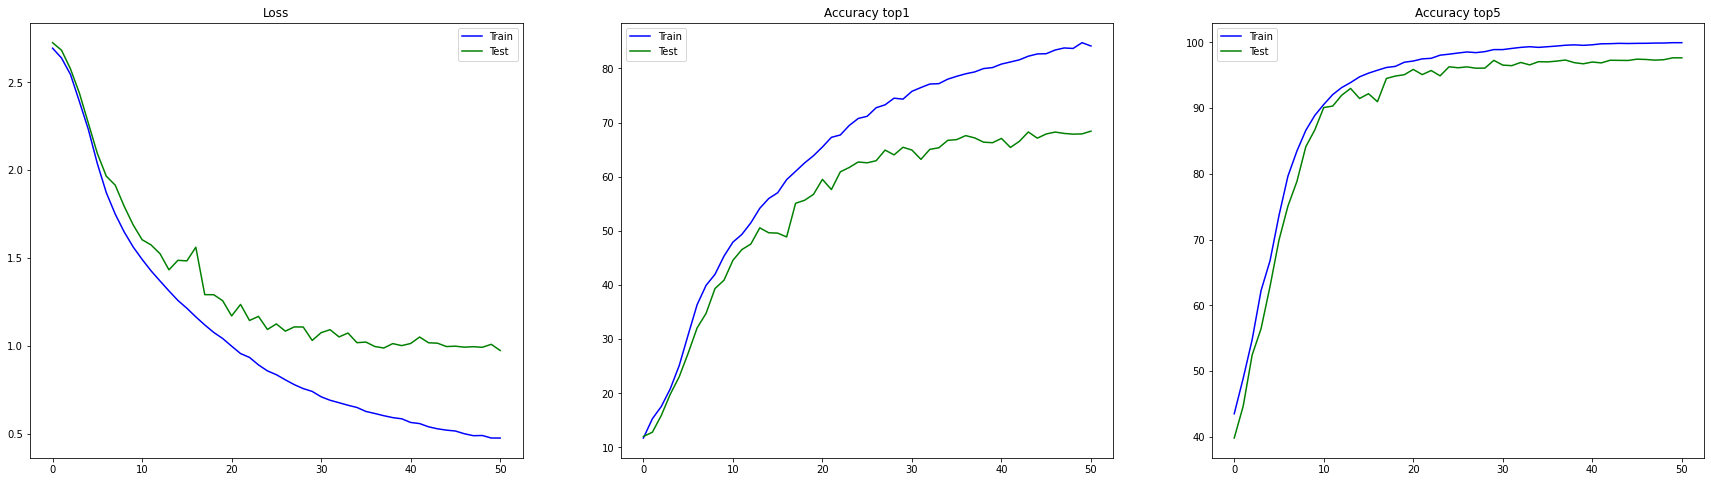

In [43]:
plot_learned(all_train_loss,all_train_acc,all_test_loss,all_test_acc,train_top5_list, test_top5_list)